 - When N and $\tau$ are different for all banks
     - can change the N and $\tau$ for each bank in the json file
 - with dynamic feed and configuration and formatting
     - if we want the feed to enter a different bank, we can just move that bank to the top
     - the 1's and 0's for that row (i.e. bank) won't change because the bank's outputs are still going to the same place

In [1]:
import numpy as np
import os, json
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

pp = pprint.PrettyPrinter(indent=4)

with open("system_config.json", "r") as f:
    config_data = json.load(f)

### Questions/worries
- worried I don't have enough results

- some functions are dependant on other functions. Any idea how I could incoporate this in a flow diagram?

## Generate circuit configurations

In [2]:
'''
    This function returns the indices that contain true (i.e. = 1) values for a given configuration.
'''
def get_circuit_indices(meta_circuit_config):
    circuit_indices = []
    for config_type in meta_circuit_config:
        type_indices = []
        for bank in config_type:
            bank_indices = []
            for i, output_flag in enumerate(bank):
                if (output_flag == 1): bank_indices.append(i)

            if bank_indices:
                type_indices.append(bank_indices)
            else:
                type_indices.append([-1])
        circuit_indices.append(type_indices)

    return circuit_indices

'''
    This function basically returns the number of possibilities/permutations for an array of indices.
    The indices in this case are not even necessarily all indices of a type (concentrate/tailings)
        array. They could also be just some of those indices. The idea is to have the total number of
        permutations for x indices.
'''
def perm(indices):
    total = 1
    for bank_indices in indices:
        total *= len(bank_indices)
           
    return total

'''
    This function takes a condensed configuration, such as [1, 3, 4], and generates the full 
        configuration matrix, such as:
        [
            [0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ]

    Called it a "type config" because it is only a configuration matrix for a specific type, ie.
        concentrate or tailings
'''
def generate_type_config(condensed_config):
    type_config = []
    size = len(condensed_config)

    for i in range(0, size):
        row = []
        for j in range(0, size + 2):
            if (j == condensed_config[i]):
                row.append(1)
            else:
                row.append(0)
        type_config.append(row)
    return np.array(type_config)

meta_circuit_config = np.array(config_data["meta_config"])

size = len(meta_circuit_config[0][0]) - 2
circuit_indices = get_circuit_indices(meta_circuit_config)
condensed_configs = [[], []]
print(circuit_indices)

for i, type_indices in enumerate(circuit_indices):
    counter = 0
    counters = []
    for j in range(0, size):
        counters.append(0)

    while (counter < perm(type_indices)):
        # pick a config
        condensed_config = []
        for j in range(0, size):
            condensed_config.append(type_indices[j][counters[j]])
            
        condensed_configs[i].append(condensed_config)
        counter += 1

        # update counters
        for j in range(0, size):
            wrap = perm(type_indices[j + 1::])
            if (counter % wrap == 0):
                counters[j] = (counters[j] + 1) % len(type_indices[j])
        
num_banks = len(config_data["meta_config"][0][0]) - 2
final_condensed_configs = []
for i in condensed_configs[0]:
    for j in condensed_configs[1]:
        if np.count_nonzero(np.array(i) == num_banks) == 1 and np.count_nonzero(np.array(j) == num_banks+1) == 1:
            final_condensed_configs.append([i, j])

final_configs = []
for condensed_config in final_condensed_configs:
    final_configs.append(np.array([generate_type_config(condensed_config[0]), generate_type_config(condensed_config[1])]))
    
#print(f'Number of configurations: {len(final_configs)}')

CPf = 4
CPs = 3
CCf = 3
CCs = 1.5
PYf = 5.1
PYs = 3.7
SC = 250
GNG = 300

# feed = np.array([CPf, CPs, CCf, CCs, PYf, PYf, PYs, SC, GNG])
feed = np.array(config_data["feed"], dtype=np.double)

# -2 because p and w are not banks
num_banks = len(config_data["meta_config"][0][0]) - 2
num_components = len(feed)
print(num_components)

pp.pprint(len(final_configs))

[[[1, 2, 3, 6], [2, 3, 6], [3, 6], [6], [1, 2, 3, 6], [1, 2, 3, 6]], [[4, 5, 7], [4, 5, 7], [4, 5, 7], [4, 5, 7], [0, 5, 7], [0, 7]]]
8
6048


## Functions

In [3]:
def inlet_mass_frac(M_component):
    if (sum(M_component) == 0):
        return np.full(M_component.shape[0], 0)
    
    Mass_frac = M_component/sum(M_component)
    return Mass_frac

def kinetic_constant():                                 
    return np.array(config_data["k_const"])

def calculate_recoveries(N, τ, bank_input):
    recoveries = []
    Rmax_1 = inlet_mass_frac(bank_input)
    for kmax, Rmax, M_comp in zip(kinetic_constant(), Rmax_1, bank_input):
        recoveries.append(Rmax*(1-(1-(1+kmax*τ)**(1-N))/((N-1)*kmax*τ)))
    return recoveries

'''
    Calculates the inputs for a bank given a circuit configuration, the circuit values at that iteration and
        a bank index (row number; rows represent banks in the config matrix)
'''
def calculate_bank_inputs(bank_index, circuit_config, circuit_values):
    num_banks = circuit_config.shape[1]
    concentrate_col = circuit_config[0][:, bank_index]
    tailings_col = circuit_config[1][:, bank_index]
    bank_inputs = np.zeros((num_components), dtype=np.double)
    for i in range(0, num_banks):
        if (concentrate_col[i] == 1):
            bank_inputs += circuit_values[i][0]
        if (tailings_col[i] == 1):
            bank_inputs += circuit_values[i][1]
            
    return bank_inputs

def bank(N, τ, bank_input):
    array_conc_out_bank = []
    array_tail_out_bank = []
    for i, R in enumerate(calculate_recoveries(N, τ, bank_input)):
        M_comp = bank_input[i]
        Mconc = M_comp*R
        Mtail = M_comp*(1-R)
        array_conc_out_bank.append(Mconc)
        array_tail_out_bank.append(Mtail)        
    
    return array_conc_out_bank, array_tail_out_bank

## Solve steady-state mass balance

In [4]:
def errf(bank_recoveries):
    total = 0
    num_banks = bank_recoveries.shape[1]
    for i in range(0, num_banks):
        for j in range(0, num_components):
            total += ( (bank_recoveries[0][i][j] - bank_recoveries[1][i][j]) ** 2 ) / (bank_recoveries[0][i][j] ** 2)
    
    return total

def get_output_banks(config):
    product = np.where(config[0][:,-2] == 1)[0]
    waste = np.where(config[1][:,-1] == 1)[0]
    return product, waste
    

crec = np.zeros((len(final_configs), num_components))
trec = np.zeros((len(final_configs), num_components))
cgrades = np.zeros((len(final_configs), num_components))
tgrades = np.zeros((len(final_configs), num_components))

for k, circuit_config in enumerate(final_configs):
    counter = 1
    bank_recoveries = np.zeros((2, num_banks, num_components))
    circuit_values = np.zeros((num_banks, 2, num_components), dtype=np.double)

    while (counter <= 2 or errf(bank_recoveries) > 0.00001):
        '''
            new_circuit_values is updated continuously and is eventually used to update circuit_values, which can
                only be updated after all banks have been calculated for the iteration as we do not want
                sequence/dependence to play a role.
        '''
        new_circuit_values = np.zeros((num_banks, 2, num_components), dtype=np.double)

        for i in range(0, num_banks):
            N, τ = config_data["banks"][i]
            # determine inputs from other banks
            bank_inputs = calculate_bank_inputs(i, circuit_config, circuit_values)

            # for the first iteration, we are working with the bank that receives an extra input, namely feed
            if (i == 0):
                new_circuit_values[i] = bank(N, τ, feed + bank_inputs)
            else:
                new_circuit_values[i] = bank(N, τ, bank_inputs)

        circuit_values = new_circuit_values
       
        # update bank recoveries
        bank_recoveries[1] = bank_recoveries[0]
        for i in range(0, num_banks):
            N, τ = config_data["banks"][i]
            bank_inputs = calculate_bank_inputs(i, circuit_config, circuit_values)
            bank_recoveries[0][i] = calculate_recoveries(N, τ, bank_inputs)

        counter += 1
        
    # calculate and store grades and recoveries
    product_bank_index, waste_bank_index = get_output_banks(circuit_config)
    for l in range(0, num_components):
        crec[k][l] = circuit_values[product_bank_index, 0][0][l] / feed[l]
        trec[k][l] = circuit_values[waste_bank_index, 1][0][l] / feed[l]

        cgrades[k][l] = circuit_values[product_bank_index, 0][0][l] / np.sum(circuit_values[product_bank_index, 0][0])
        tgrades[k][l] = circuit_values[waste_bank_index, 1][0][l] / np.sum(circuit_values[waste_bank_index, 1][0])

    if (counter == 3): continue

    print("Iterations required to reach steady state: {}\n".format(counter))
    print("\t\t", end="")
    for i in range(0, num_components):
        print("\tComponent{}\t".format(i+1), end="")
    print("\n")
    for i in range(0, num_banks):
        concentrate = "\t".join(["{:f}".format(i) for i in circuit_values[i][0]])
        tailings = "\t".join(["{:f}".format(i) for i in circuit_values[i][1]])
        print("Concentrate:\t{}\nTailings:\t{}\tBank{}\n".format(concentrate, tailings, i+1))
    
    print("\nCircuit configuration")
    print("Concentrate\t\t\tTailings\n")
    for i in range(0, num_banks):
        conc = "  ".join(["{:d}".format(k) for k in circuit_config[0][i]])
        tail = "  ".join(["{:d}".format(k) for k in circuit_config[1][i]])
        print("{}\t\t{}".format(conc, tail))
            
    
    print("\n\n")

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


Iterations required to reach steady state: 462

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.190248	1.475296	1.477394	0.732141	1.686433	0.922844	78.542557	170.018599
Tailings:	44.766013	87.240664	87.093970	61.764929	224.215429	495.377278	3182.514286	822.763251	Bank1

Concentrate:	0.000061	0.006351	0.006391	0.001545	0.001890	0.000066	1.113070	175.483571
Tailings:	0.190342	1.487520	1.489643	0.735154	1.696623	0.921126	84.463533	80.254221	Bank2

Concentrate:	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000593	167.441433
Tailings:	0.000061	0.006351	0.006391	0.001545	0.001890	0.000066	1.112480	8.041219	Bank3

Concentrate:	0.000119	0.004745	0.004744	0.001192	0.007094	0.000356	4.459865	176.153170
Tailings:	0.289136	1.506577	1.504507	0.756322	3.367794	2.131863	166.554970	121.155261	Bank4

Concentrate:	0.000283	0.018658	0.018722	0.004620	0.012241	0.000524	7.036017	85.716860
Tailings:	0.479063	2.981718	2.981747	1.488

Iterations required to reach steady state: 556

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.304295	2.897030	2.904865	1.439929	2.557578	1.208632	112.535579	194.772637
Tailings:	66.759292	143.741482	143.588319	101.941400	325.582297	668.732326	4491.727202	1058.596251	Bank1

Concentrate:	0.000152	0.023815	0.024028	0.005804	0.004182	0.000109	1.975133	139.191557
Tailings:	0.304045	2.911670	2.919634	1.443422	2.559970	1.205500	113.707515	91.940002	Bank2

Concentrate:	0.000000	0.000004	0.000004	0.000000	0.000000	0.000000	0.002335	131.743656
Tailings:	0.000152	0.023811	0.024024	0.005804	0.004182	0.000109	1.972798	7.447901	Bank3

Concentrate:	0.000246	0.015546	0.015584	0.003840	0.013356	0.000489	8.019380	151.602076
Tailings:	0.451642	2.958118	2.958113	1.474077	5.020731	2.714608	241.268368	148.225910	Bank4

Concentrate:	0.000250	0.038679	0.039022	0.009506	0.006881	0.000181	3.150219	36.358488
Tailings:	0.303795	2.872991	2.880612

Iterations required to reach steady state: 604

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.306198	2.940090	2.948481	1.445814	2.535463	1.252974	115.208105	200.243102
Tailings:	67.749791	146.503547	146.358185	103.352256	327.985325	688.805850	4597.627066	1085.396610	Bank1

Concentrate:	0.000168	0.026178	0.026417	0.006330	0.004480	0.000129	2.146717	114.491858
Tailings:	0.305891	2.913806	2.921959	1.439393	2.530838	1.251169	113.059784	85.752227	Bank2

Concentrate:	0.000000	0.000026	0.000027	0.000002	0.000000	0.000000	0.015613	141.936837
Tailings:	0.000411	0.064846	0.065442	0.015560	0.010963	0.000314	5.399695	11.242421	Bank3

Concentrate:	0.000258	0.015583	0.015620	0.003859	0.013412	0.000550	8.022138	151.538530
Tailings:	0.462594	2.962522	2.962510	1.478179	5.032748	2.880645	241.386684	148.320654	Bank4

Concentrate:	0.000243	0.038697	0.039056	0.009232	0.006485	0.000186	3.268633	38.686321
Tailings:	0.305934	2.939869	2.94825

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	2.427501	38.503131	38.496043	23.515656	55.486058	5.428109	944.697355	503.162286
Tailings:	514.584131	1420.649709	1417.109557	1116.816325	4116.258635	3869.779838	35467.153913	4995.413465	Bank1

Concentrate:	0.002146	0.910542	0.913272	0.339502	0.434900	0.000492	29.274925	146.611229
Tailings:	2.423420	37.589865	37.580059	23.169635	55.030935	5.423184	915.390722	356.537785	Bank2

Concentrate:	0.000000	0.010092	0.010139	0.001407	0.002234	0.000000	3.294916	233.835281
Tailings:	0.006771	2.223676	2.226583	0.832738	1.805329	0.002275	135.122353	112.103598	Bank3

Concentrate:	0.002500	0.472478	0.470866	0.172538	1.080921	0.001558	108.725598	186.972112
Tailings:	3.430827	38.573460	38.461748	23.422904	106.783578	11.545131	2077.524863	606.097834	Bank4

Concentrate:	0.004635	1.323427	1.323650	0.495064	1.373897	0.001786	109.144203	199.329576
Tailings:	5.844917	74.834464	74.712758	46.084513	16

Iterations required to reach steady state: 810

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.429742	2.957520	2.957607	1.473039	4.953072	1.973176	237.974663	250.455832
Tailings:	107.472787	197.639222	197.172852	140.095614	613.305843	1156.966728	8827.051085	1673.827499	Bank1

Concentrate:	0.000188	0.015215	0.015268	0.003748	0.009760	0.000181	5.738206	157.395165
Tailings:	0.429420	2.962631	2.962708	1.474217	4.961812	1.968039	244.505899	154.532762	Bank2

Concentrate:	0.000000	0.000001	0.000001	0.000000	0.000000	0.000000	0.017055	145.793196
Tailings:	0.000188	0.015214	0.015267	0.003748	0.009759	0.000181	5.721149	11.602155	Bank3

Concentrate:	0.000240	0.011883	0.011879	0.002948	0.017192	0.000369	10.748990	195.075006
Tailings:	0.509109	2.951546	2.947601	1.473071	6.492999	2.689524	318.230781	192.606641	Bank4

Concentrate:	0.509349	2.963427	2.959479	1.476019	6.510190	2.689893	328.962678	241.886574
Tailings:	107.402507	197.596

Iterations required to reach steady state: 576

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.216204	1.496144	1.497252	0.739841	2.167619	1.211925	112.043137	177.717404
Tailings:	54.661971	100.806424	100.603797	71.199931	291.100136	650.050072	4347.969994	984.555865	Bank1

Concentrate:	0.000092	0.007459	0.007495	0.001824	0.003603	0.000133	2.233968	99.226163
Tailings:	0.216005	1.488625	1.489697	0.737972	2.163843	1.209172	109.806976	78.492963	Bank2

Concentrate:	0.000000	0.000004	0.000004	0.000000	0.000001	0.000000	0.091214	155.427448
Tailings:	0.000450	0.026673	0.026749	0.006583	0.022137	0.000929	14.210388	19.715924	Bank3

Concentrate:	0.000104	0.004992	0.004998	0.001241	0.005507	0.000240	3.664982	183.920387
Tailings:	0.264463	1.512020	1.511014	0.755266	2.904442	1.713013	148.050160	113.381047	Bank4

Concentrate:	0.264567	1.517009	1.516008	0.756507	2.909950	1.713258	151.623959	141.871812
Tailings:	54.378246	99.302604	99.1

Iterations required to reach steady state: 2124

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	2.255851	36.790376	36.779296	22.327605	56.455112	5.004425	1111.906568	509.204003
Tailings:	522.580061	1465.201636	1461.473623	1147.768623	4374.783876	3913.276529	40486.654507	5315.714141	Bank1

Concentrate:	0.001677	0.752433	0.754512	0.277016	0.407455	0.000379	36.706113	135.902978
Tailings:	2.252367	36.035341	36.022196	22.044409	56.024498	4.999766	1075.162952	373.289190	Bank2

Concentrate:	0.000000	0.008961	0.008995	0.001253	0.002485	0.000000	5.324303	197.420838
Tailings:	0.006548	2.135587	2.137488	0.800684	1.939719	0.002090	173.942850	126.427838	Bank3

Concentrate:	0.002196	0.564488	0.563885	0.212308	0.711000	0.000801	69.363213	172.673932
Tailings:	2.728521	35.654108	35.592041	21.999666	73.528577	7.022328	1412.533241	474.104771	Bank4

Concentrate:	2.732888	36.212158	36.149437	22.216757	74.267122	7.028559	1476.622076	449.37055

Iterations required to reach steady state: 726

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.367377	2.918086	2.922170	1.443845	3.726291	1.697826	178.902635	207.174937
Tailings:	87.818474	173.208153	172.914986	122.445894	470.282541	948.555893	6768.572911	1339.813356	Bank1

Concentrate:	0.000199	0.021119	0.021249	0.005170	0.007924	0.000194	4.239289	100.365301
Tailings:	0.367009	2.896882	2.900835	1.438604	3.718122	1.695087	174.660948	106.810479	Bank2

Concentrate:	0.000000	0.000004	0.000004	0.000000	0.000000	0.000000	0.014513	92.428307
Tailings:	0.000198	0.021114	0.021244	0.005169	0.007923	0.000194	4.224734	7.938186	Bank3

Concentrate:	0.000243	0.015555	0.015593	0.003848	0.013252	0.000382	8.011780	151.747159
Tailings:	0.449214	2.957385	2.957402	1.474785	4.998372	2.399631	241.022321	148.061143	Bank4

Concentrate:	0.449329	2.945401	2.945323	1.471932	4.996655	2.401941	240.203137	166.152225
Tailings:	87.342186	170.246807	16

Iterations required to reach steady state: 464

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.190437	1.480127	1.482256	0.733549	1.688524	0.924048	78.960925	172.345178
Tailings:	44.927326	87.655958	87.509267	62.017181	225.052857	497.236602	3200.888218	830.299575	Bank1

Concentrate:	0.000083	0.008412	0.008465	0.002066	0.002519	0.000089	1.278560	107.538118
Tailings:	0.190228	1.471633	1.473710	0.731422	1.685845	0.921793	77.680418	64.809369	Bank2

Concentrate:	0.000000	0.000001	0.000001	0.000000	0.000000	0.000000	0.001269	102.037052
Tailings:	0.000083	0.008411	0.008464	0.002066	0.002519	0.000089	1.277291	5.501066	Bank3

Concentrate:	0.000114	0.004692	0.004691	0.001160	0.006859	0.000342	4.697260	182.941533
Tailings:	0.289407	1.529661	1.527679	0.761857	3.381379	2.132873	174.495382	126.403468	Bank4

Concentrate:	0.000294	0.019408	0.019474	0.004804	0.012730	0.000546	7.317143	74.266890
Tailings:	0.479149	2.981816	2.981844	1.488

Iterations required to reach steady state: 445

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.189020	1.474527	1.476627	0.731555	1.684907	0.902439	78.524179	170.040654
Tailings:	44.569532	87.114587	86.968147	61.667412	223.850622	489.306132	3178.337238	821.644293	Bank1

Concentrate:	0.000065	0.006788	0.006831	0.001648	0.002016	0.000067	1.210357	155.392830
Tailings:	0.189254	1.487749	1.489874	0.734848	1.695997	0.902908	85.148374	77.495523	Bank2

Concentrate:	0.000192	0.007310	0.007304	0.001835	0.012315	0.000611	7.962581	52.158118
Tailings:	0.287201	1.503345	1.501281	0.755139	3.359838	2.084194	163.022112	77.669630	Bank3

Concentrate:	0.000000	0.000001	0.000001	0.000000	0.000000	0.000000	0.028287	189.264300
Tailings:	0.000257	0.014096	0.014133	0.003484	0.014330	0.000678	9.144602	18.290824	Bank4

Concentrate:	0.000299	0.020010	0.020078	0.004942	0.013107	0.000538	7.834541	62.848085
Tailings:	0.476264	2.985090	2.985120	1.4884

Iterations required to reach steady state: 633

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.314855	2.930408	2.938362	1.454426	2.583056	1.306014	118.127858	197.530691
Tailings:	69.331384	147.639589	147.483152	104.622334	334.094623	709.688444	4697.957529	1091.119572	Bank1

Concentrate:	0.000153	0.022750	0.022954	0.005540	0.003996	0.000120	2.049334	151.216992
Tailings:	0.314920	2.940595	2.948640	1.456852	2.584853	1.306063	119.656787	97.605205	Bank2

Concentrate:	0.000349	0.019855	0.019895	0.004889	0.019173	0.000829	12.906156	63.263630
Tailings:	0.465997	2.979854	2.979878	1.483616	5.050502	2.926222	249.373237	109.010096	Bank3

Concentrate:	0.000000	0.000008	0.000008	0.000000	0.000001	0.000000	0.071006	190.854647
Tailings:	0.000501	0.042595	0.042839	0.010428	0.023168	0.000949	14.884429	23.628454	Bank4

Concentrate:	0.000218	0.032940	0.033235	0.007968	0.005793	0.000172	3.578295	51.291435
Tailings:	0.314964	2.950087	2.9580

Iterations required to reach steady state: 537

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.213805	1.479019	1.480085	0.734229	2.149786	1.170782	106.057722	169.292910
Tailings:	53.071419	97.836439	97.638739	69.241213	283.018084	623.837805	4130.808453	938.332083	Bank1

Concentrate:	0.000074	0.006093	0.006122	0.001482	0.002936	0.000101	2.039856	146.032436
Tailings:	0.214088	1.492402	1.493477	0.737558	2.165586	1.171437	116.610506	92.900891	Bank2

Concentrate:	0.000177	0.007977	0.007982	0.002001	0.010000	0.000427	6.147150	57.952196
Tailings:	0.262701	1.497616	1.496581	0.752093	2.889237	1.662391	137.189025	72.613809	Bank3

Concentrate:	0.000000	0.000001	0.000001	0.000000	0.000000	0.000000	0.023017	186.738702
Tailings:	0.000251	0.014068	0.014102	0.003483	0.012935	0.000528	8.163927	17.249786	Bank4

Concentrate:	0.263037	1.505652	1.504622	0.754141	2.899484	1.666987	143.338829	130.569371
Tailings:	52.808382	96.330786	96.13411

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	1.914005	59.960414	59.974159	27.449760	61.913984	4.208395	1907.372661	662.672955
Tailings:	597.490226	2317.496871	2312.193650	1581.156244	5691.793937	4450.883151	65645.191487	7576.307009	Bank1

Concentrate:	0.000772	1.277458	1.282350	0.267557	0.313190	0.000171	69.050856	147.143171
Tailings:	1.911898	58.672781	58.681705	27.168759	61.564874	4.205482	1838.239820	515.508331	Bank2

Concentrate:	0.000982	0.990399	0.990230	0.202454	0.595870	0.000380	169.266245	151.487390
Tailings:	2.255705	60.116026	60.050107	27.425247	80.920478	5.712543	2570.332532	617.406301	Bank3

Concentrate:	0.000000	0.009401	0.009463	0.000403	0.000452	0.000000	7.624147	156.454952
Tailings:	0.001752	2.257820	2.262486	0.469174	0.907602	0.000550	230.687512	142.175016	Bank4

Concentrate:	2.257240	59.783717	59.714471	27.355691	81.068258	5.716936	2628.408443	669.462135
Tailings:	597.242574	2317.481314	2312.183669	1

Iterations required to reach steady state: 449

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.189310	1.474705	1.476804	0.731691	1.685261	0.907135	78.528423	170.035545
Tailings:	44.615610	87.143724	86.997225	61.689962	223.935017	490.708195	3179.302876	821.903017	Bank1

Concentrate:	0.000083	0.008442	0.008495	0.002078	0.002537	0.000087	1.278409	105.810828
Tailings:	0.189227	1.466263	1.468309	0.729612	1.682724	0.907048	77.250013	64.224717	Bank2

Concentrate:	0.000155	0.006032	0.006028	0.001495	0.009980	0.000496	6.990594	97.265368
Tailings:	0.287970	1.524417	1.522418	0.760456	3.375675	2.095751	171.682970	100.458301	Bank3

Concentrate:	0.000000	0.000001	0.000001	0.000000	0.000000	0.000000	0.023572	185.802333
Tailings:	0.000238	0.014472	0.014521	0.003573	0.012517	0.000583	8.245380	17.277806	Bank4

Concentrate:	0.000294	0.019640	0.019708	0.004852	0.012869	0.000533	7.682038	67.888506
Tailings:	0.476998	2.985423	2.985452	1.488

Iterations required to reach steady state: 599

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.305729	2.929708	2.937749	1.446111	2.550732	1.238827	119.040011	207.712430
Tailings:	68.587818	148.201592	148.046813	104.733976	333.301094	693.890429	4734.207042	1118.817109	Bank1

Concentrate:	0.000162	0.025127	0.025350	0.006122	0.004383	0.000122	2.215454	119.081738
Tailings:	0.305434	2.904499	2.912317	1.439913	2.546243	1.237678	116.823485	88.630951	Bank2

Concentrate:	0.000319	0.018577	0.018614	0.004569	0.017926	0.000730	12.017906	82.498334
Tailings:	0.459984	2.977331	2.977361	1.481243	5.043512	2.834902	249.306773	120.627372	Bank3

Concentrate:	0.000000	0.000009	0.000009	0.000001	0.000001	0.000000	0.068371	179.220043
Tailings:	0.000481	0.043692	0.043953	0.010689	0.022307	0.000850	14.164938	22.361861	Bank4

Concentrate:	0.000253	0.038521	0.038859	0.009467	0.006812	0.000190	3.328158	33.818079
Tailings:	0.305032	2.865872	2.8733

Iterations required to reach steady state: 573

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.215888	1.480194	1.481258	0.735102	2.153152	1.220309	106.099425	169.256812
Tailings:	53.445445	98.092250	97.893954	69.435239	283.862791	638.268140	4140.878684	940.675121	Bank1

Concentrate:	0.000097	0.007674	0.007711	0.001893	0.003737	0.000142	2.105691	94.600936
Tailings:	0.215791	1.472520	1.473546	0.733209	2.149415	1.220167	103.993734	74.655877	Bank2

Concentrate:	0.000180	0.007982	0.007987	0.002004	0.010022	0.000463	6.147046	57.965048
Tailings:	0.265240	1.498616	1.497578	0.752879	2.893317	1.732944	137.233836	72.657273	Bank3

Concentrate:	0.000000	0.000005	0.000005	0.000000	0.000001	0.000000	0.134824	189.355933
Tailings:	0.000646	0.035433	0.035515	0.008786	0.032815	0.001439	20.904125	28.751031	Bank4

Concentrate:	0.265544	1.506649	1.505616	0.754923	2.903547	1.737060	143.383184	130.625198
Tailings:	53.179901	96.585601	96.38833


			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	2.574790	35.388176	35.381875	22.410383	52.661346	5.784748	827.170614	409.039339
Tailings:	500.641627	1286.653584	1283.449958	1029.650136	3788.257124	3774.950479	31372.934243	4276.310652	Bank1

Concentrate:	0.002798	0.891610	0.894294	0.357447	0.454156	0.000648	26.016267	112.312784
Tailings:	2.569901	34.494320	34.485345	22.047754	52.191361	5.779259	801.126560	296.717433	Bank2

Concentrate:	0.003767	0.502029	0.500118	0.197489	1.384792	0.002590	120.344358	72.862039
Tailings:	3.652588	35.496363	35.393894	22.380775	101.440030	12.344210	1791.055126	368.368466	Bank3

Concentrate:	0.000000	0.013397	0.013439	0.002147	0.005933	0.000000	7.869241	154.031142
Tailings:	0.012822	2.719801	2.720767	1.092004	3.315965	0.005671	236.634906	145.204381	Bank4

Concentrate:	0.006278	1.339768	1.340002	0.539668	1.484808	0.002442	98.146973	114.061174
Tailings:	6.211130	68.646444	68.534789	43.878557	152

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.305933	2.970619	2.979104	1.456692	2.557176	1.237426	120.903749	209.976190
Tailings:	69.037294	150.154589	150.005944	105.771035	335.800902	697.800606	4800.474783	1132.021206	Bank1

Concentrate:	0.000161	0.025515	0.025747	0.006135	0.004351	0.000120	2.257165	120.189621
Tailings:	0.305639	2.945019	2.953272	1.450479	2.552718	1.236278	118.645513	89.786805	Bank2

Concentrate:	0.000340	0.019828	0.019869	0.004874	0.019129	0.000775	12.902214	63.285159
Tailings:	0.459527	2.977019	2.977046	1.480987	5.043225	2.828353	249.263549	108.969537	Bank3

Concentrate:	0.000000	0.000030	0.000030	0.000002	0.000001	0.000000	0.105983	190.876518
Tailings:	0.000749	0.084358	0.084982	0.020477	0.030227	0.001080	18.438118	26.820443	Bank4

Concentrate:	0.000249	0.039049	0.039401	0.009472	0.006751	0.000187	3.384772	34.220486
Tailings:	0.305238	2.905862	2.913763	1.440911	2.545814	1.234327	115.259117	55.5650

Iterations required to reach steady state: 540

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.214063	1.479158	1.480224	0.734333	2.150190	1.176613	106.062665	169.288603
Tailings:	53.117190	97.866828	97.669058	69.264271	283.118692	625.549370	4132.005293	938.610655	Bank1

Concentrate:	0.000108	0.006108	0.006120	0.001513	0.005149	0.000200	3.388871	112.020951
Tailings:	0.263428	1.518292	1.517288	0.757293	2.912566	1.671659	151.993245	100.599944	Bank2

Concentrate:	0.000083	0.005509	0.005528	0.001352	0.003922	0.000151	2.543884	190.938451
Tailings:	0.213960	1.479687	1.480746	0.734442	2.151215	1.173756	106.905179	90.372332	Bank3

Concentrate:	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.002437	179.439449
Tailings:	0.000083	0.005509	0.005528	0.001352	0.003922	0.000151	2.541451	11.498411	Bank4

Concentrate:	0.263193	1.505711	1.504681	0.754188	2.899729	1.671127	143.341462	130.572707
Tailings:	52.831253	96.345986	96.149

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.429503	2.979001	2.979172	1.478241	4.957244	1.968251	238.515367	258.275214
Tailings:	107.769447	198.953943	198.487212	140.769229	615.433128	1159.026012	8864.257781	1701.727458	Bank1

Concentrate:	0.000250	0.009707	0.009688	0.002374	0.023184	0.000550	17.844457	109.812478
Tailings:	0.616802	2.955730	2.947836	1.464243	9.530249	4.277002	532.346489	215.028189	Bank2

Concentrate:	0.000208	0.013888	0.013918	0.003408	0.013036	0.000263	8.688912	203.530411
Tailings:	0.429103	2.974702	2.974825	1.477099	4.966621	1.963217	247.666125	164.556244	Bank3

Concentrate:	0.000000	0.000001	0.000001	0.000000	0.000000	0.000000	0.025921	185.862625
Tailings:	0.000208	0.013888	0.013917	0.003408	0.013036	0.000263	8.662998	17.667304	Bank4

Concentrate:	0.000239	0.019503	0.019571	0.004786	0.012460	0.000229	7.661891	68.357072
Tailings:	0.429069	2.969083	2.969168	1.475718	4.967172	1.963242	248.667013	113.

Iterations required to reach steady state: 558

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.304434	2.884416	2.891987	1.437680	2.563581	1.207523	114.268516	197.878307
Tailings:	67.183545	144.326790	144.167488	102.492814	327.964610	672.509556	4553.602984	1073.147745	Bank1

Concentrate:	0.000248	0.018311	0.018374	0.004495	0.011984	0.000409	7.184475	86.569244
Tailings:	0.451473	2.973780	2.973814	1.477966	5.033885	2.708704	249.279069	125.312090	Bank2

Concentrate:	0.000160	0.020071	0.020217	0.004954	0.005342	0.000152	2.987987	186.224973
Tailings:	0.304171	2.882439	2.889927	1.437017	2.569915	1.204574	118.461846	98.222974	Bank3

Concentrate:	0.000000	0.000002	0.000002	0.000000	0.000000	0.000000	0.003438	174.509046
Tailings:	0.000160	0.020069	0.020215	0.004954	0.005342	0.000152	2.984554	11.715435	Bank4

Concentrate:	0.000239	0.036080	0.036390	0.008968	0.006600	0.000172	3.254465	39.498675
Tailings:	0.303933	2.846359	2.853537

Iterations required to reach steady state: 2630

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	1.544418	78.431169	78.590509	25.629947	54.146510	3.385620	3131.525044	891.393357
Tailings:	653.070939	3227.397030	3222.853221	1864.143700	6487.607314	4854.787948	102102.826950	10726.143118	Bank1

Concentrate:	0.000399	1.139363	1.144451	0.126712	0.226513	0.000118	174.033470	116.622319
Tailings:	1.880135	76.257006	76.294253	25.683950	71.710386	4.766306	3965.207069	689.828506	Bank2

Concentrate:	0.000323	1.254559	1.262466	0.126070	0.189783	0.000094	228.647609	297.797986
Tailings:	1.544395	80.806316	80.974564	25.887277	54.701870	3.383581	3570.566401	988.517731	Bank3

Concentrate:	0.000000	0.002948	0.002993	0.000030	0.000020	0.000000	7.197941	159.579938
Tailings:	0.000323	1.250744	1.258606	0.125903	0.189546	0.000093	221.438876	138.217007	Bank4

Concentrate:	1.881707	77.424420	77.466645	25.825232	71.979723	4.769079	4139.505942	806.4

Iterations required to reach steady state: 576

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.216210	1.496428	1.497530	0.740038	2.169125	1.209907	112.824682	179.869170
Tailings:	54.838736	101.144126	100.940606	71.440144	292.141778	651.597433	4377.076211	993.170833	Bank1

Concentrate:	0.000134	0.007436	0.007452	0.001850	0.006303	0.000257	4.026910	63.843706
Tailings:	0.264225	1.508720	1.507698	0.754274	2.903397	1.708723	148.646470	80.839856	Bank2

Concentrate:	0.000092	0.006110	0.006131	0.001487	0.004322	0.000173	3.136714	155.035469
Tailings:	0.216144	1.497694	1.498789	0.740355	2.170932	1.207359	113.712660	88.678684	Bank3

Concentrate:	0.000000	0.000003	0.000003	0.000000	0.000001	0.000000	0.081395	191.972021
Tailings:	0.000464	0.026168	0.026230	0.006445	0.023641	0.000997	16.045701	24.680979	Bank4

Concentrate:	0.264359	1.516157	1.515150	0.756124	2.909701	1.708985	152.673384	144.683584
Tailings:	54.555015	99.640584	99.43

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.190475	1.479555	1.481671	0.733562	1.689547	0.923403	79.174619	174.900761
Tailings:	45.031635	87.836405	87.689060	62.156469	225.622072	498.164524	3212.372966	837.384139	Bank1

Concentrate:	0.000154	0.007119	0.007123	0.001785	0.008149	0.000384	4.927347	54.635440
Tailings:	0.288853	1.505799	1.503734	0.755726	3.366205	2.128713	167.313138	81.869594	Bank2

Concentrate:	0.000068	0.005857	0.005886	0.001414	0.002552	0.000096	1.860741	204.863647
Tailings:	0.190742	1.501197	1.503359	0.738926	1.708392	0.922084	90.257471	81.891554	Bank3

Concentrate:	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.001221	193.336890
Tailings:	0.000068	0.005857	0.005886	0.001413	0.002552	0.000096	1.859523	11.526303	Bank4

Concentrate:	0.000309	0.020463	0.020533	0.005056	0.013411	0.000572	8.018169	57.218206
Tailings:	0.479094	2.986462	2.986489	1.489539	5.060898	3.045179	249.549249	106.540053	Bank5

Iterations required to reach steady state: 560

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.304618	2.920768	2.928730	1.446965	2.568395	1.207359	115.909449	196.322703
Tailings:	67.485040	145.832347	145.678571	103.252993	329.648349	675.270815	4604.945204	1074.971983	Bank1

Concentrate:	0.000270	0.020017	0.020086	0.004910	0.013093	0.000446	7.889068	61.119298
Tailings:	0.451301	2.973529	2.973562	1.477747	5.033770	2.707018	249.274890	109.241316	Bank2

Concentrate:	0.000151	0.019736	0.019886	0.004753	0.005046	0.000142	3.065224	203.177181
Tailings:	0.304602	2.955163	2.963352	1.455184	2.582110	1.204619	124.079363	103.923307	Bank3

Concentrate:	0.000000	0.000002	0.000002	0.000000	0.000000	0.000000	0.003319	190.580441
Tailings:	0.000151	0.019734	0.019884	0.004753	0.005046	0.000142	3.061902	12.596800	Bank4

Concentrate:	0.000214	0.034335	0.034644	0.008269	0.005976	0.000153	3.349175	49.659469
Tailings:	0.304537	2.940554	2.94858

Iterations required to reach steady state: 906

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.449624	2.963643	2.963735	1.477907	4.974147	2.246214	230.196926	237.046446
Tailings:	108.937093	196.051055	195.588495	139.060740	609.076981	1223.260605	8606.004514	1618.331258	Bank1

Concentrate:	0.000319	0.011040	0.011017	0.002746	0.027133	0.000836	18.739956	62.741939
Tailings:	0.647675	2.928257	2.920233	1.463204	9.578435	4.899875	505.291420	165.468105	Bank2

Concentrate:	0.000259	0.015599	0.015631	0.003865	0.014906	0.000389	9.289107	153.067838
Tailings:	0.449372	2.958990	2.959026	1.476711	4.985885	2.241855	239.643852	146.719767	Bank3

Concentrate:	0.000000	0.000005	0.000005	0.000000	0.000001	0.000000	0.091970	189.919842
Tailings:	0.000527	0.035586	0.035687	0.008784	0.027800	0.000693	17.041887	25.460702	Bank4

Concentrate:	0.000268	0.019993	0.020062	0.004920	0.012897	0.000305	7.844761	62.313032
Tailings:	0.449631	2.974582	2.9

Iterations required to reach steady state: 950

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.448295	3.012808	3.012954	1.490134	5.036053	2.211162	274.206855	259.422152
Tailings:	116.163468	211.216196	210.720102	149.172383	654.609609	1295.926592	10021.954908	1812.815182	Bank1

Concentrate:	0.000232	0.012766	0.012776	0.003100	0.013999	0.000342	11.556304	117.656855
Tailings:	0.529476	3.016429	3.012523	1.489490	6.598394	3.004294	382.826849	181.845520	Bank2

Concentrate:	0.000264	0.016439	0.016474	0.004021	0.015527	0.000387	11.579073	117.757309
Tailings:	0.447725	2.996281	2.996393	1.486040	5.020057	2.206174	262.623842	141.663841	Bank3

Concentrate:	0.000000	0.000003	0.000003	0.000000	0.000001	0.000000	0.150812	204.066188
Tailings:	0.000496	0.029202	0.029246	0.007120	0.029523	0.000727	22.984526	31.348165	Bank4

Concentrate:	0.529369	3.007923	3.003983	1.487360	6.592246	3.004157	380.484916	253.555178
Tailings:	116.112536	211.

Iterations required to reach steady state: 766

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.373267	2.944902	2.949067	1.454077	3.752295	1.763804	184.037015	214.867855
Tailings:	89.789871	176.522959	176.225570	124.654620	478.720418	980.649920	6963.353470	1383.145503	Bank1

Concentrate:	0.000251	0.018260	0.018323	0.004494	0.011874	0.000343	7.142233	88.126114
Tailings:	0.454996	2.975117	2.975166	1.480515	5.019902	2.485230	249.033533	126.042653	Bank2

Concentrate:	0.000244	0.020916	0.021017	0.005099	0.011480	0.000328	6.945844	107.576588
Tailings:	0.372875	2.923909	2.927974	1.448916	3.740603	1.761128	177.089003	107.291883	Bank3

Concentrate:	0.000000	0.000007	0.000007	0.000000	0.000001	0.000000	0.068908	173.775043
Tailings:	0.000495	0.039168	0.039332	0.009592	0.023351	0.000670	14.019093	21.928552	Bank4

Concentrate:	0.455074	2.964873	2.964849	1.478044	5.016186	2.487365	247.269655	177.018727
Tailings:	89.311402	173.582810	

Iterations required to reach steady state: 1008

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.456613	3.014883	3.015051	1.492106	5.041807	2.343234	267.855708	279.474273
Tailings:	117.220827	211.267437	210.771967	149.255678	654.917607	1333.873405	9907.397220	1871.154439	Bank1

Concentrate:	0.000258	0.009086	0.009068	0.002209	0.021864	0.000713	20.777592	105.983564
Tailings:	0.653136	2.980994	2.973051	1.472158	9.647312	5.074475	597.977849	226.617369	Bank2

Concentrate:	0.000268	0.016057	0.016091	0.003933	0.015180	0.000424	10.776882	133.300211
Tailings:	0.456094	2.998748	2.998882	1.488110	5.026247	2.338517	257.075282	146.173060	Bank3

Concentrate:	0.000000	0.000002	0.000002	0.000000	0.000002	0.000000	0.267823	201.268327
Tailings:	0.000525	0.025140	0.025156	0.006142	0.037040	0.001134	31.286646	38.015691	Bank4

Concentrate:	0.000292	0.021270	0.021343	0.005238	0.013751	0.000352	8.347832	47.645522
Tailings:	0.455797	2.977476	

Iterations required to reach steady state: 960

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.452590	2.991508	2.991605	1.485536	5.021531	2.283288	259.569979	245.473182
Tailings:	114.250071	205.985481	205.499910	145.777914	639.807296	1289.089602	9547.160466	1727.852621	Bank1

Concentrate:	0.000275	0.014468	0.014478	0.003567	0.016134	0.000425	11.174946	84.393098
Tailings:	0.535516	2.979006	2.975022	1.482762	6.573601	3.109699	348.834512	151.072486	Bank2

Concentrate:	0.000253	0.015399	0.015431	0.003771	0.014580	0.000387	10.762258	144.952087
Tailings:	0.452398	2.996787	2.996895	1.486806	5.026264	2.278888	262.332307	152.385533	Bank3

Concentrate:	0.000000	0.000004	0.000004	0.000000	0.000001	0.000000	0.139514	199.276826
Tailings:	0.000528	0.029862	0.029905	0.007337	0.030711	0.000810	21.797672	30.068333	Bank4

Concentrate:	0.535794	2.993475	2.989501	1.486331	6.589753	3.110137	360.009519	235.465616
Tailings:	114.203011	205.97

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.373362	2.973794	2.978140	1.460974	3.764231	1.761629	191.090864	220.555452
Tailings:	91.130012	180.029820	179.730757	126.809155	486.596194	994.513736	7199.307411	1422.327193	Bank1

Concentrate:	0.000268	0.019553	0.019620	0.004810	0.012708	0.000366	7.671933	68.043736
Tailings:	0.454801	2.975186	2.975235	1.480568	5.020093	2.481812	249.024354	113.902908	Bank2

Concentrate:	0.000210	0.018667	0.018760	0.004465	0.010008	0.000282	7.098256	141.055605
Tailings:	0.373308	2.981735	2.986120	1.462870	3.768421	1.759430	193.551028	124.303039	Bank3

Concentrate:	0.000000	0.000006	0.000007	0.000000	0.000001	0.000000	0.070982	185.913236
Tailings:	0.000478	0.038212	0.038373	0.009274	0.022714	0.000646	14.699140	23.186852	Bank4

Concentrate:	0.455233	2.994794	2.994910	1.485427	5.033012	2.484398	256.698167	181.948311
Tailings:	90.651285	177.058845	176.759856	125.321824	481.539904	991.309298	6956

Iterations required to reach steady state: 586

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.216567	1.480606	1.481669	0.735407	2.154315	1.237848	106.114049	169.244288
Tailings:	53.570172	98.181619	97.983114	69.503003	284.156944	643.320695	4144.394135	941.492576	Bank1

Concentrate:	0.000147	0.007952	0.007967	0.001997	0.006799	0.000295	3.845053	56.340952
Tailings:	0.266102	1.499000	1.497950	0.753162	2.897956	1.758110	139.551559	74.300988	Bank2

Concentrate:	0.000120	0.007709	0.007735	0.001902	0.005517	0.000235	3.366896	97.316170
Tailings:	0.216354	1.472840	1.473877	0.733463	2.148636	1.235163	102.745115	71.929859	Bank3

Concentrate:	0.000000	0.000005	0.000005	0.000000	0.000001	0.000000	0.123059	190.089448
Tailings:	0.000640	0.035523	0.035605	0.008810	0.031464	0.001390	19.933477	27.966590	Bank4

Concentrate:	0.266249	1.506951	1.505918	0.755159	2.904755	1.758405	143.396611	130.641940
Tailings:	53.286739	96.662226	96.46478

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.457755	2.966212	2.966296	1.479993	4.986716	2.380428	230.306304	237.060256
Tailings:	110.250870	196.743054	196.278645	139.587484	611.718233	1263.062637	8634.998539	1624.040550	Bank1

Concentrate:	0.000330	0.011052	0.011028	0.002752	0.027251	0.000939	18.738223	62.749570
Tailings:	0.659533	2.931019	2.922982	1.465384	9.603208	5.194940	505.485272	165.568580	Bank2

Concentrate:	0.000273	0.015932	0.015965	0.003940	0.015100	0.000444	8.608754	158.455971
Tailings:	0.457756	2.970031	2.970150	1.480919	4.984401	2.380322	229.426995	144.516113	Bank3

Concentrate:	0.000000	0.000003	0.000003	0.000000	0.000002	0.000000	0.219179	187.415634
Tailings:	0.000602	0.026980	0.026990	0.006691	0.042347	0.001381	27.127688	33.791857	Bank4

Concentrate:	0.000274	0.019751	0.019819	0.004866	0.012785	0.000338	7.729451	65.911790
Tailings:	0.457830	2.977176	2.977237	1.482677	5.013568	2.376897	248.821807	112.

Iterations required to reach steady state: 605

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.306503	2.968429	2.976956	1.455194	2.550777	1.246771	118.761445	207.930387
Tailings:	68.671112	149.151641	149.005085	105.053146	333.289240	696.076893	4728.590408	1119.236540	Bank1

Concentrate:	0.000283	0.020124	0.020193	0.004948	0.013185	0.000497	7.915098	60.273670
Tailings:	0.461255	2.977608	2.977634	1.481551	5.044886	2.855209	249.348946	108.691636	Bank2

Concentrate:	0.000180	0.023821	0.024010	0.005648	0.005822	0.000179	3.337933	151.232431
Tailings:	0.306442	2.984069	2.992771	1.458922	2.551505	1.245765	118.768052	92.603032	Bank3

Concentrate:	0.000000	0.000009	0.000009	0.000001	0.000000	0.000000	0.041405	191.158384
Tailings:	0.000463	0.043934	0.044192	0.010594	0.019004	0.000675	11.211569	20.349433	Bank4

Concentrate:	0.000247	0.039546	0.039911	0.009452	0.006653	0.000187	3.345594	35.905112
Tailings:	0.306049	2.944415	2.95275

Iterations required to reach steady state: 955

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.456466	2.965790	2.965875	1.479655	4.984733	2.357989	230.288261	237.057937
Tailings:	110.040611	196.628982	196.164878	139.500887	611.288001	1256.474015	8630.217801	1623.099225	Bank1

Concentrate:	0.000328	0.011050	0.011026	0.002751	0.027233	0.000921	18.738517	62.748351
Tailings:	0.657652	2.930565	2.922530	1.465031	9.599301	5.145598	505.453276	165.551982	Bank2

Concentrate:	0.000312	0.018119	0.018156	0.004510	0.017305	0.000502	9.288864	111.834418
Tailings:	0.456153	2.947671	2.947719	1.475145	4.967428	2.357486	220.999396	125.223519	Bank3

Concentrate:	0.000000	0.000009	0.000009	0.000001	0.000004	0.000000	0.349914	192.472217
Tailings:	0.000920	0.049458	0.049542	0.012259	0.057662	0.001763	35.624906	40.922565	Bank4

Concentrate:	0.000280	0.020299	0.020369	0.004999	0.013130	0.000341	7.947554	58.810209
Tailings:	0.456530	2.976744	2.9

Iterations required to reach steady state: 603

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	0.306527	2.969517	2.978029	1.456209	2.552963	1.245200	118.686150	207.252095
Tailings:	68.638819	149.101142	148.954210	105.035146	333.260319	695.285102	4724.668033	1117.075515	Bank1

Concentrate:	0.000283	0.020109	0.020178	0.004944	0.013174	0.000495	7.907900	60.461548
Tailings:	0.460838	2.977421	2.977448	1.481397	5.044441	2.848775	249.316787	108.817989	Bank2

Concentrate:	0.000201	0.025975	0.026176	0.006246	0.006491	0.000200	3.528236	122.239475
Tailings:	0.306196	2.943458	2.951769	1.449886	2.546368	1.243981	115.156862	85.012851	Bank3

Concentrate:	0.000000	0.000032	0.000033	0.000002	0.000001	0.000000	0.069064	191.031704
Tailings:	0.000743	0.086579	0.087215	0.021020	0.026642	0.000890	14.680183	23.547297	Bank4

Concentrate:	0.000260	0.040531	0.040898	0.009834	0.006980	0.000197	3.313180	31.876289
Tailings:	0.305790	2.902820	2.91076

In [5]:
print(len(final_configs))

6048


## Sorted based on grade

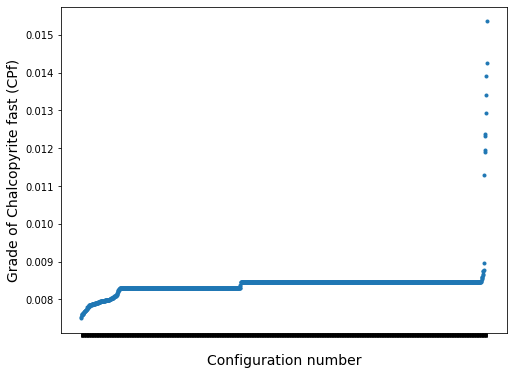

Optimal configuration based on grade = 530
[[[0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 1 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0]]]


In [6]:
Cgrades_c1_unsorted = [x for x in tgrades[:,1] if np.isnan(x) == False]


list_configs = [i for i in range(1, len(final_configs) + 1)]
Cgrades_c1, list_configs_sorted = [list(v) for v in zip(*sorted(zip(Cgrades_c1_unsorted,list_configs)))]
list_configs_sorted_string = [str(x) for x in list_configs_sorted]

Cgrades_c1_sufficient = []
config_number_sufficient = []

for a, i in enumerate(Cgrades_c1):
    if i > 0.0075:
        Cgrades_c1_sufficient.append(i)
        config_number_sufficient.append(list_configs_sorted_string[a])

plt.figure(figsize=(8, 6))
plt.plot(config_number_sufficient, Cgrades_c1_sufficient, '.')
plt.xlabel('Configuration number', fontsize=14)
plt.ylabel('Grade of Chalcopyrite fast (CPf)', fontsize=14)
plt.savefig("Grade vs config number.jpg", bbox_inches='tight')
plt.xticks(color='w')
# plt.xlim(40, 90)
plt.show()

print(f'Optimal configuration based on grade = {config_number_sufficient[-1]}')
print(final_configs[int(config_number_sufficient[-1])-1])

## Sorted based on recovery

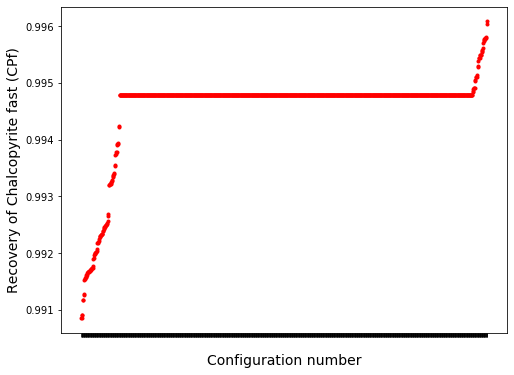

Optimal configuration based on recovery = 3750
[[[0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0]
  [0 1 0 0 0 0 0 0]]

 [[0 0 0 0 0 1 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0]]]


In [7]:
Crec_c1_unsorted = [x for x in trec[:,1] if np.isnan(x) == False]

list_configs = [i for i in range(1, len(final_configs) + 1)]
Crecs_c1, list_configs_sorted = [list(v) for v in zip(*sorted(zip(Crec_c1_unsorted,list_configs)))]
list_configs_sorted_string = [str(x) for x in list_configs_sorted]

Crecs_c1_sufficient = []
config_number_sufficient = []

for a, i in enumerate(Crecs_c1):
    if i > 0.99:
        Crecs_c1_sufficient.append(i)
        config_number_sufficient.append(list_configs_sorted_string[a])

# plt.figure(figsize=(20, 6))
# plt.plot(config_number_sufficient, Crecs_c1_sufficient,'*', color='r')
# plt.xlabel('Configuration number')
# plt.ylabel('Recovery')
# plt.xlim(15, 60)
# plt.savefig("Recovery vs config number.jpg")
# plt.show()

plt.figure(figsize=(8, 6))
plt.plot(config_number_sufficient, Crecs_c1_sufficient,'.', color='r')
plt.xlabel('Configuration number', fontsize=14)
plt.ylabel('Recovery of Chalcopyrite fast (CPf)', fontsize=14)
# plt.xlim(40, 90)
plt.xticks(color='w')
plt.savefig("Recovery vs config number.jpg", bbox_inches='tight')
plt.show()

print(f'Optimal configuration based on recovery = {config_number_sufficient[-1]}')
print(final_configs[int(config_number_sufficient[-1])-1])

# Objective function

#### Revenue

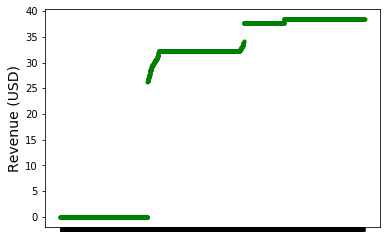

Optimal configuration number based on revenue = 17
[[[0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 1 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]]

 [[0 0 0 0 1 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 1]
  [0 0 0 0 0 1 0 0]
  [1 0 0 0 0 0 0 0]]]


In [8]:
p = 0.975
μ = 0.015/1000000
q = 8
Trc = 0.15/10000
Rfc = 0.3
H = 7200

list_configs = [i for i in range(1, len(final_configs) + 1)]


Component_flow_rates_tail = (trec*(config_data["feed"]))[:,0]


Revenue_unsorted = H*Component_flow_rates_tail*(p*(tgrades[:,0]-μ)*(q-Rfc)-Trc)
Revenue_remove_nan_and_zeros = [x for x in Revenue_unsorted if np.isnan(x) == False and x!=0]

list_configs = [i for i in range(1, len(final_configs) + 1)]
Revenue, list_configs_sorted = [list(v) for v in zip(*sorted(zip(Revenue_remove_nan_and_zeros,list_configs)))]
list_configs_sorted_string = [str(x) for x in list_configs_sorted]


plt.plot(list_configs_sorted_string, Revenue,'.', color='g')
plt.xticks(color='w')
plt.ylabel('Revenue (USD)', fontsize=14)
plt.savefig("Revenue vs config number.jpg", bbox_inches='tight')
# plt.ylim(30, 40)
plt.show()



optimal_config_revenue = np.array(list_configs_sorted_string)[np.where(Revenue==np.max(Revenue))][0]
print(f'Optimal configuration number based on revenue = {optimal_config_revenue}')

print(final_configs[np.max(list_configs_sorted)-1])

#### Profit before taxes

In [9]:
Fk = np.array(config_data["feed"])*1000
MFk = Fk/sum(Fk)
Ni = np.array(config_data["banks"])[:,0]
τi = np.array(config_data["banks"])[:,1]
ρ_k = np.array([4190, 4190, 5500, 5500, 5000, 5000, 2650, 2000])

ρ_p = 1/(sum(MFk/ρ_k))
print(ρ_p)

Vi = np.sum(Fk)*τi/ρ_p

If = 2000000
td = 3.636/100


Pk = 0.3055   # Hawaii
Cop = np.sum(Ni*Vi*Pk*H)
print(f'Cop = {Cop}')

PB = Revenue - Cop - If/td
# print(PB)

2287.761238986797
Cop = 263759564.25734448


#### Calculate Vcell from $\tau$

$\tau$ = $\frac{Vcell\cdot\rho}{Feed}$

In [10]:
N = np.array(config_data["banks"])[:,0]
τ = np.array(config_data["banks"])[:,1]
feed = np.array(config_data["feed"])
ρfeed = np.array([1000, 1000, 1000, 1000])

Vcell_per_bank = τ*feed/ρfeed*N
print(f'Volume of cells per bank = {Vcell_per_bank}')

ValueError: operands could not be broadcast together with shapes (7,) (8,) 

In [ ]:
def Capital_cost():
    FL = 3
    FLw = 0.9
    Ifi = 105.7 + 10.72*sum(Vcell_per_bank) - 149.1*sum(Vcell_per_bank)**2
    
    If = FL*Ifi
    Iw = FLw*Ifi
    
    return If, Iw

If = Capital_cost()[0]
Iw = Capital_cost()[1]

print(f'Fixed capital (If) = {If}')
print(f'Wokring capital (Iw) = {Iw}')

In [ ]:
def Revenue():
    p = 0.975
    µ = 0.015
    Trc = 0.15
    Rfc = 0.3
    H = 7200
    q = 8
    
    Revenue = (p*(max(Cgrades_c1)-µ)*(q-Rfc) - Trc)*H
    
    return Revenue

Revenue = Revenue()
print(f'Revenue = {Revenue}')

In [ ]:
Vi_list = np.linspace(1, 15)
Ifi_list = (105.7 + 10.72*Vi_list + 149.1*Vi_list**2)#/Vi_list

plt.plot(Vi_list, Ifi_list)

In [ ]:
Vi = 0.1
Ifi_list = 105.7 + 10.72*Vi - 149.1*Vi**2

print(Ifi_list)